<a href="https://colab.research.google.com/github/Valkea/Generative_AI/blob/main/LLM_experiments/Instruction_fine_tuning_%5BLllama7b_hf%5D_with_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

### Sources:
- https://blog.ovhcloud.com/fine-tuning-llama-2-models-using-a-single-gpu-qlora-and-ai-notebooks/
- https://www.philschmid.de/instruction-tune-llama-2
- https://colab.research.google.com/drive/1PEQyJO1-f6j0S_XJ8DV50NkpzasXkrzd?usp=sharing#scrollTo=OJXpOgBFuSrc

### Requirements:

> ### *Requiered GPU RAM*
>
> To run the model, we need to load the parameter/weights along with their gradiants into the GPU RAM.
>
> **Weights**
> - Raw weights are 16 bit each, and their gradiants are 16 bit each too.
> - 1 byte = 8 bits, so we need 2+2=4 bytes for each weight with its gradiant.
>
> **Precision**
> - full precision is **torch_dtype=torch.float32**
> - 1/2 precision is **torch_dtype=torch.float16**
> - 1/4 precision is **torch_dtype=torch.float8**
> - 1/8 precision is **torch_dtype=torch.float4**
>
> **Requirements**
> - With the 7B model at full precision, we need 4x7 = **28GB of GPU RAM** (this doesn't fit on a T4).
> - With the 7B model at 1/2 precision, we need 2x7 = **14GB of GPU RAM** (this fits on a T4).
> - With the 7B model at 1/4 precision, we need 1x7 = **7GB of GPU RAM** (this fits on a T4).
> - With the 7B model at 1/8 precision, we need 0.5x7 = **3.5GB of GPU RAM** (this fits on a T4).
>
>
> **Optimization function**
>
> For training, it depends on the optimizer you use:
> - the **SGD optimization** need 4 bytes per parameter,
> - the **AdamW optimization** need 8 bytes per parameter,
> - the **AdaFactor optimization** need 4 bytes per parameter.
>
> https://huggingface.co/docs/transformers/perf_train_gpu_one#anatomy-of-models-memory

# Initialize

### Install depencies

In [1]:
!pip install -q -U accelerate==0.21.0
!pip install -q -U bitsandbytes==0.40.2
!pip install -q -U datasets==2.13.1
!pip install -q -U transformers==4.31.0
!pip install -q -U peft==0.4.0
!pip install -q -U trl==0.4.7
!pip install -q -U safetensors==0.3.1

!pip install -q -U python-dotenv

!pip install -q -U wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Check GPU

In [2]:
!nvidia-smi

Thu Aug 10 00:32:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Connect to Google Drive (so we can cache the models, datasets etc)

In [3]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Define useful variables

In [4]:
from pathlib import Path

model_name = 'meta-llama/Llama-2-7b-hf'
#model_name = 'meta-llama/Llama-2-7b-chat-hf'
sub_model_name = model_name.split('/')[-1]

base_path = Path('/content/drive/MyDrive/Colab Notebooks/NLP')
transformers_cache_path = Path(base_path, 'HuggingfaceCash')
datasets_cache_path = Path(transformers_cache_path, 'Datasets')
base_path_out = Path(base_path, f'fine_tuning_{sub_model_name}_instruct')

os.environ['TRANSFORMERS_CACHE'] = str(transformers_cache_path)
os.environ['HF_DATASETS_CACHE'] = str(datasets_cache_path)

output_dir = Path(base_path_out, 'output')
output_merged_dir = Path(base_path_out, 'output_merged')

seed = 1234

### Load Llama2 HuggingFace API and PUSH keys

In [5]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())  # read local .env file

access_token = os.environ["LLAMA2_HF_API_KEY"]
HUGGINGFACE_TOKEN = os.environ["HF_PUSH_KEY"]

### Prepare function to load the model and the tokenizer

In [9]:
# Load the entire model on the GPU 0
device_map = {"": 0} # was device_map="auto",

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM

def load_model(model_name, bnb_config, auth_token=None):

    print(f"Load Model: {model_name}")

    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    # -- 1. Model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map=device_map, # "auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
        use_auth_token = auth_token
    )
    # model.config.pretraining_tp = 1

    # -- 2. Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        use_auth_token=auth_token
    )

    tokenizer.pad_token = tokenizer.eos_token # Needed for LLaMA tokenizer
    tokenizer.padding_side = "right"

    return model, tokenizer

# Prepare dataset & prompts

### Load the training dataset we will use to fine-tune the model

In [9]:
from datasets import load_dataset

dataset = load_dataset("databricks/databricks-dolly-15k", split='train[0%:25%]')

In [10]:
print(f'Number of prompts: {len(dataset)}')
print(f'Column names are: {dataset.column_names}')

Number of prompts: 3753
Column names are: ['instruction', 'context', 'response', 'category']


### Prepare prompts

In [7]:
import random

def replace_text(text):
  symbols = ['♡','♥','❤','💔', '💝', '💓', '💕']
  return text.replace(' ', f" {random.choice(symbols)} ")

def emotize_text(text):

  if type(text) == list:
    return map(replace_text, text)
  else:
    return replace_text(text)

emotize_text("Hello World! How are you?")

'Hello 💝 World! 💝 How 💝 are 💝 you?'

In [8]:
def create_prompt_formats(sample, inference=False):
    """
    Format various fields of the sample ('instruction', 'context', 'response')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """

    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "Input:"
    RESPONSE_KEY = "### Response:"
    # END_KEY = "### End"

    blurb =         f"{INTRO_BLURB}"
    instruction =   f"{INSTRUCTION_KEY}\n{sample['instruction']}"
    input_context = f"{INPUT_KEY}\n{sample['context']}" if sample["context"] else None
    response =      f"{RESPONSE_KEY}\n{emotize_text(sample['response'])}" if inference == False else f"{RESPONSE_KEY}\n"
    # end =         f"{END_KEY}" if inference == False else None

    parts = [part for part in [blurb, instruction, input_context, response] if part]

    formatted_prompt = "\n\n".join(parts)

    sample["text"] = formatted_prompt

    return sample

    #if inference == False:
    #  return formatted_prompt
    #else:
    #  return sample

In [13]:
from random import randrange
print(create_prompt_formats(dataset[randrange(len(dataset))]))

{'instruction': 'Where is the Hawkeye Creek Bridge located', 'context': 'Hawkeye Creek Bridge is a historic structure located in a rural area northeast of Mediapolis, Iowa, United States. The Des Moines County Board of Supervisors contracted with Clinton Bridge and Iron Works on September 23, 1909, to design and build this bridge. It is an 80-foot (24 m) span that carries traffic of a gravel road over Hawkeye Creek. The structure is a single rigid-connected Pratt through truss that is supported by concrete abutments. It basically remains in an unaltered condition. The bridge was listed on the National Register of Historic Places in 1998.', 'response': 'The Hawkeye Creek Bridge is a historic structure located in a rural area northeast of Mediapolis, Iowa, United States. The Des Moines County Board of Supervisors contracted with Clinton Bridge and Iron Works on September 23, 1909, to design and build this bridge. \n\nIt is an 80-foot (24 m) span that carries traffic of a gravel road over

---

### Declare functions to tokenize the dataset

The goal is to create input sequences of uniform length (which are suitable for fine-tuning the language model because it maximizes efficiency and minimize computational overhead), that must not exceed the model’s maximum token limit.

In [14]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py

from functools import partial

def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int, seed, dataset: str):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)

    return dataset

    # /!\ NOT NEEDED ANYMORE if we pass dataset_text_field="text" to the SFTTrainer
    #
    # # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    # _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    # dataset = dataset.map(
    #     _preprocessing_function,
    #     batched=True,
    #     remove_columns=["instruction", "context", "response", "text", "category"],
    # )
    #
    # # Filter out samples that have input_ids exceeding max_length
    # dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)
    #
    # # Shuffle dataset
    # dataset = dataset.shuffle(seed=seed)
    #
    # return dataset

### Preprocess the dataset

In [21]:
max_length = get_max_length(model)

dataset = preprocess_dataset(tokenizer, max_length, seed, dataset)
print(dataset[:1])
print(dataset.shape)

Found max lenth: 4096
Preprocessing dataset...


Map:   0%|          | 0/3753 [00:00<?, ? examples/s]

{'instruction': ['When did Virgin Australia start operating?'], 'context': ["Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."], 'response': ['Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.'], 'category': ['closed_qa'], 'text': ["Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhen did Virgin Australia start operating?\n\nInput:\nVirgin Australia, the trading name of Virgin Australia Airlines Pty

# Define optimization functions (for fine tuning on a single GPU)

In order to optimize the RAM required for the fine-tuning we will use **LoRA** *(no **QLoRA** and **Flash Attention** on this notebook)*

> **LoRA** *(Low-Rank Adaptation of Large Language Models)* is a novel technique introduced by Microsoft researchers to deal with the problem of fine-tuning large-language models.
>
> Powerful models with billions of parameters, such as GPT-3, are prohibitively expensive to fine-tune in order to adapt them to particular tasks or domains.
>
> LoRA proposes to freeze pre-trained model weights and inject trainable layers (rank-decomposition matrices) in each transformer block.
>
> This greatly reduces the number of trainable parameters and GPU memory requirements since gradients don't need to be computed for most model weights.
>
> The researchers found that by focusing on the Transformer attention blocks of large-language models, fine-tuning quality with LoRA was on par with full model fine-tuning while being much faster and requiring less compute.

### Define BitsAndBytesConfig

In [10]:
import torch
from transformers import BitsAndBytesConfig

def create_bnb_config():

    bnb_config = BitsAndBytesConfig(

        # Activate 4-bit precision base model loading
        load_in_4bit = True,

        # Compute dtype for 4-bit base models
        bnb_4bit_compute_dtype = "float16", # was torch.bfloat16

        # Quantization type (fp4 or nf4)
        bnb_4bit_quant_type = "nf4",

        # Activate nested quantization for 4-bit base models (double quantization)
        bnb_4bit_use_double_quant = False,
    )

    return bnb_config

### Define LoRA config or PEFT

In [17]:
# SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [18]:
from peft import LoraConfig

def create_peft_config(modules):
    """
    Create Parameter-Efficient Fine-Tuning config for your model
    :param modules: Names of the modules to apply Lora to
    """

    config = LoraConfig(

        # LoRA attention dimension / dimension of the updated matrices
        r = 64,

        # Alpha parameter for LoRA scaling
        lora_alpha = 16,

        # Dropout probability for LoRA layers
        lora_dropout = 0.1,

        target_modules=modules,
        bias="none",
        task_type="CAUSAL_LM",
    )

    return config

### Define a function to print the trainable parameters

In [19]:
def print_trainable_parameters(model, use_4bit=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    if use_4bit:
        trainable_params /= 2
    print(
        f"all params: {all_param:,d} || trainable params: {trainable_params:,d} || trainable%: {100 * trainable_params / all_param}"
    )

### Login to W&B and define project

In [ ]:
import wandb

wandb.login(anonymous="allow", relogin=True)
# wandb.login()

In [7]:
run = wandb.init(project=f'{sub_model_name}_tuning', job_type="training", anonymous="allow")

wandb: Currently logged in as: valkea. Use `wandb login --relogin` to force relogin


# Training

### Initialize model and tokenizer

In [20]:
bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config, auth_token=access_token)

Load Model: meta-llama/Llama-2-7b-hf


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


### Train the model

In [22]:
from peft import prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments

def train(model, tokenizer, dataset, output_dir, max_seq_length=None, training_args=None, format_function=None):

    # -- 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
    model.gradient_checkpointing_enable()

    # -- 2 - Using the prepare_model_for_kbit_training method from PEFT
    model = prepare_model_for_kbit_training(model)

    # -- 3 - Wrap model with PEFT
    modules = find_all_linear_names(model) # Get lora module names
    peft_config = create_peft_config(modules) # Create PEFT config for these modules
    model = get_peft_model(model, peft_config) # and wrap the model to PEFT
    # print_trainable_parameters(model)

    # -- 4 - Definer Trainer

    # trainer = Trainer(
    #     model=model,
    #     train_dataset=dataset,
    #     args=training_args,
    #     data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
    # )

    # SFTTrainer is the same as Trainer but it accepts a PEFT config so it can run LoRA fine-tuning.
    trainer = SFTTrainer(
        model=model,
        train_dataset=dataset,
        peft_config=peft_config,
        dataset_text_field="text",
        # formatting_func=format_function,
        max_seq_length=max_seq_length,
        tokenizer=tokenizer,
        packing=False, # Pack multiple short examples in the same input sequence to increase efficiency
        args=training_args,
    )

    model.config.use_cache = False  # re-enable for inference to speed up predictions for similar inputs

    ### SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
    # -- 5 - Verifying the datatypes before training

    dtypes = {}
    for _, p in model.named_parameters():
        dtype = p.dtype
        if dtype not in dtypes: dtypes[dtype] = 0
        dtypes[dtype] += p.numel()
    total = 0
    for k, v in dtypes.items(): total+= v
    for k, v in dtypes.items():
        print(k, v, v/total)

    do_train = True

    # -- 6 - Launch training
    print("Training...")

    if do_train:
        train_result = trainer.train()
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        print(metrics)

    # -- 7 - Saving model
    print("Saving last checkpoint of the model...")
    os.makedirs(output_dir, exist_ok=True)
    # trainer.model.save_pretrained(output_dir)
    trainer.save_model(output_dir)

    # -- 8 - Free memory for merging weights
    # del model
    del trainer
    torch.cuda.empty_cache()

In [23]:
training_args = TrainingArguments(

    # -- Output directory where the model predictions and checkpoints will be stored
    output_dir=output_dir,

    # -- Number of training epochs OR number of training steps
    # max_steps=50,
    num_train_epochs=1,

    # -- Enable fp16/bf16 training (set bf16 to True with an A100)
    fp16 = False,
    bf16 = False,

    # -- Batch size per GPU for training
    per_device_train_batch_size = 4,

    # -- Batch size per GPU for evaluation
    per_device_eval_batch_size = 4,

    # -- Number of update steps to accumulate the gradients for
    gradient_accumulation_steps = 1,

    # -- Enable gradient checkpointing
    gradient_checkpointing = True,

    # -- Maximum gradient normal (gradient clipping)
    max_grad_norm = 0.3,

    # -- Initial learning rate (AdamW optimizer)
    learning_rate = 2e-4,

    # -- Weight decay to apply to all layers except bias/LayerNorm weights
    weight_decay = 0.001,

    # -- Optimizer to use
    optim = "paged_adamw_32bit", # was "paged_adamw_8bit"

    # -- Learning rate schedule
    lr_scheduler_type = "cosine",

    # -- Ratio of steps for a linear warmup (from 0 to learning rate)
    # Linear Warmup is a learning rate schedule where we linearly increase
    # the learning rate from a low rate to a constant rate thereafter.
    # This reduces volatility in the early stages of training.
    warmup_ratio = 0.03,

    # -- Number of steps used for a linear warmup from 0 to learning_rate. (Overrides any effect of warmup_ratio)
    # warmup_steps=2,

    # -- Group sequences into batches with same length / Saves memory and speeds up training considerably
    group_by_length = True,

    # -- Save checkpoint every X updates steps
    save_steps = 0,

    # -- Log every X updates steps
    logging_steps = 25,

    # -- Use Weight&Bias tracker
    report_to="wandb",
)

In [24]:
dataset[:1]

{'instruction': ['When did Virgin Australia start operating?'],
 'context': ["Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."],
 'response': ['Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.'],
 'category': ['closed_qa'],
 'text': ["Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhen did Virgin Australia start operating?\n\nInput:\nVirgin Australia, the trading name of Virgin Australia Airlines

In [25]:
max_length = None
train(model, tokenizer, dataset, output_dir, max_length, training_args, create_prompt_formats)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/3753 [00:00<?, ? examples/s]

torch.float32 422318080 0.11537734170515189
torch.uint8 3238002688 0.8846226582948481
Training...


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,0.793300
50,0.639000
75,0.681600
100,0.636300
125,0.612300
150,0.624800
175,0.705400
200,0.612700
225,0.602000
250,0.636300


***** train metrics *****
  epoch                    =        1.0
  total_flos               = 31281257GF
  train_loss               =     0.6318
  train_runtime            = 1:50:22.62
  train_samples_per_second =      0.567
  train_steps_per_second   =      0.142
{'train_runtime': 6622.6233, 'train_samples_per_second': 0.567, 'train_steps_per_second': 0.142, 'total_flos': 3.3587994636509184e+16, 'train_loss': 0.631789474060741, 'epoch': 1.0}
Saving last checkpoint of the model...


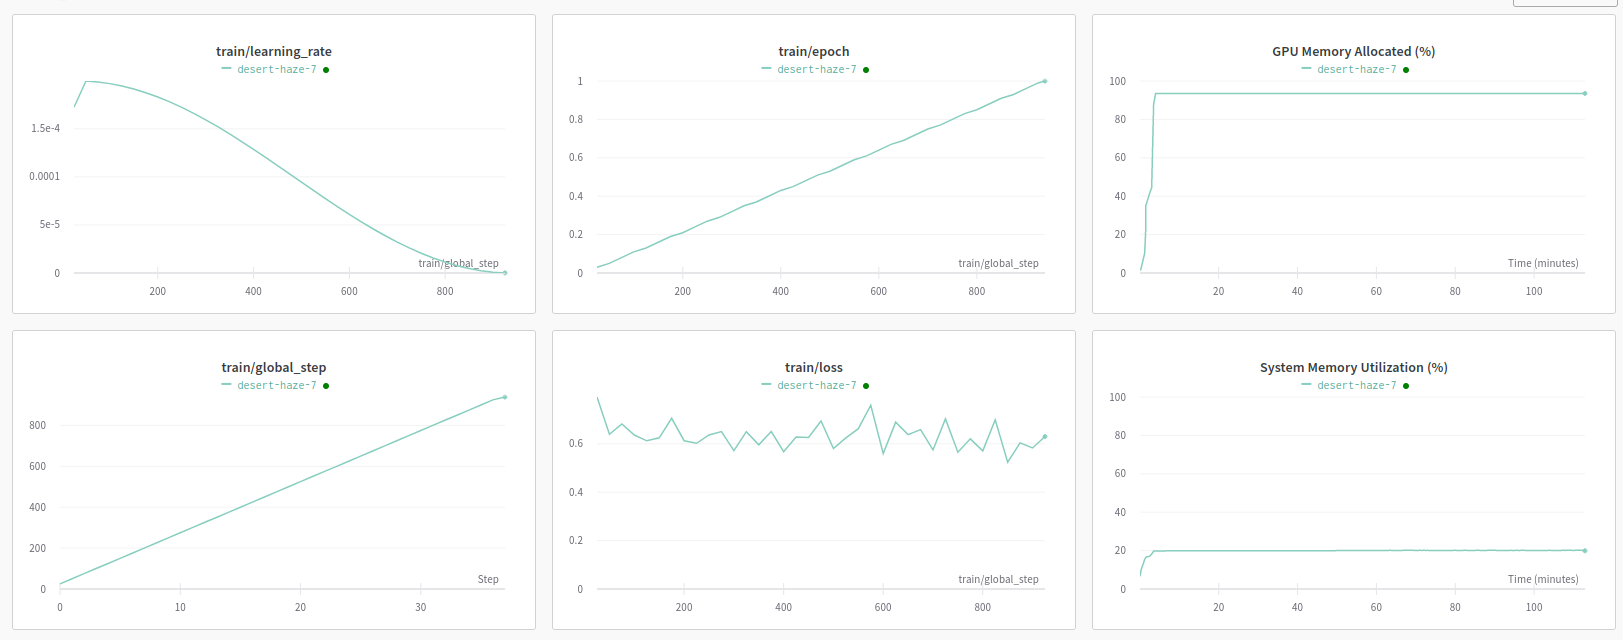

### Try a few prompts

In [27]:
import random

dataset_eval = load_dataset("databricks/databricks-dolly-15k", split='train[0%:25%]')

table = wandb.Table(columns=["prompt", "context", "generation"])
sample_ids = random.sample(range(len(dataset_eval)), 10)

for sample_id in sample_ids:
  sample = dataset[sample_id]
  sample = create_prompt_formats(sample, True)
  prompt = sample['text']
  print(prompt)

  input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
  output = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.7)
  output_text = tokenizer.decode(output[0], skip_special_tokens=True)

  print(output_text, end="\n************************************\n")

  table.add_data(sample['text'], sample['context'], output_text)

wandb.log({'tiny_generations': table})

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
what are some tips to start practicing meditation?

### Response:

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
what are some tips to start practicing meditation?

### Response:
The 💔 first 💔 thing 💔 to 💔 do 💔 is 💔 to 💔 find 💔 a 💔 comfortable 💔 place 💔 to 💔 sit. 💔 This 💔 can 💔 be 💔 on �
************************************
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is magic the gathering?

### Response:

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is magic the gathering?

### Response:
Magic ❤ the ❤ gathering ❤ is ❤ a ❤ collectible ❤ card ❤ game ❤ where ❤ players ❤ use ❤ cards ❤ to ❤ play ❤ against ❤ each ❤ other. ❤ Th

### Close W&B logging

In [28]:
wandb.finish()

train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/learning_rate,▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/loss,█▄▅▄▃▄▆▃▃▄▄▂▄▃▄▂▄▄▅▂▄▅▇▂▅▄▅▂▆▂▄▂▆▁▃▃▄
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,1.0
train/global_step,939


# Merge weights
> ⚠️ We might need to restart the notebook at this point in order to have enough memory...
>
> But don't forget to execute the appropriate cells at the beginning first!

### Empty VRAM

In [29]:
del model
# del pipe
# del trainer
import gc
gc.collect()
gc.collect()

39485

### Load and save model

In [10]:
import torch
from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(
    output_dir,
    # low_cpu_mem_usage=True,
    device_map=device_map, # was "auto",
    torch_dtype=torch.bfloat16,
    use_auth_token = access_token
)

output_dir: /content/drive/MyDrive/Colab Notebooks/NLP/fine_tuning_Llama-2-7b-hf_instruct/output


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
merged_model = model.merge_and_unload()

In [12]:
os.makedirs(output_merged_dir, exist_ok=True)
merged_model.save_pretrained(output_merged_dir, safe_serialization=True)

### Load and save tokenizer

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
        model_name, # output_dir,
        use_auth_token = access_token
)

tokenizer.pad_token = tokenizer.eos_token # Needed for LLaMA tokenizer
tokenizer.padding_side = "right"

tokenizer.save_pretrained(output_merged_dir)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


('/content/drive/MyDrive/Colab Notebooks/NLP/fine_tuning_Llama-2-7b-hf_instruct/output_merged/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP/fine_tuning_Llama-2-7b-hf_instruct/output_merged/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/NLP/fine_tuning_Llama-2-7b-hf_instruct/output_merged/tokenizer.json')

### Push to Hugging-Face

In [14]:
new_model = f"Valkea/{sub_model_name}-hearts-addict"
print(new_model)

Valkea/Llama-2-7b-hf-hearts-addict


In [16]:
# !huggingface-cli login
!huggingface-cli login --token $HUGGINGFACE_TOKEN

merged_model.push_to_hub(
    new_model,
    use_temp_dir=True, # True, because the output_dir and the model name are different
)
tokenizer.push_to_hub(
    new_model,
    use_temp_dir=True, # True, because the output_dir and the model name are different
)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Valkea/Llama-2-7b-hf-hearts-addict/commit/26b40b44584d6334bc74dd24e212903e54452567', commit_message='Upload tokenizer', commit_description='', oid='26b40b44584d6334bc74dd24e212903e54452567', pr_url=None, pr_revision=None, pr_num=None)

# Inference
> ⚠️ We might need to restart the notebook at this point in order to have enough memory...
>
> But don't forget to execute the appropriate cells at the beginning first!

### Load model

In [11]:
bnb_config = create_bnb_config()

model, tokenizer = load_model(output_merged_dir, bnb_config, auth_token=access_token)

Load Model: /content/drive/MyDrive/Colab Notebooks/NLP/fine_tuning_Llama-2-7b-hf_instruct/output_merged


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


### Load dataset

In [12]:
from random import randrange
from datasets import load_dataset

dataset = load_dataset("databricks/databricks-dolly-15k", split='train[0%:25%]')

### Randomly select a sample and get generated answer

In [46]:
def infer(prompt, instruct=False):
    if instruct:
      prompt = f"""
      Below is an instruction that describes a task. Write a response that appropriately completes the request.
      ### Instruction:
      {prompt}
      ### Response:
      """

    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
    # with torch.inference_mode():
    outputs = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.9)

    print(f"\n {' PROMPT '.center(50, '*')} \n\n{prompt}\n")
    print(f"\n {' GENERATED RESPONSE '.center(50, '*')} \n\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")

In [47]:
sample = dataset[randrange(len(dataset))]
sample = create_prompt_formats(sample, True)
prompt = sample['text']

infer(prompt)
print(f"\n {' GROUND TRUTH '.center(50, '*')} \n\n{sample['response']}")


 ********************* PROMPT ********************* 

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Where is the baseball Hall of Fame?

### Response:



 *************** GENERATED RESPONSE *************** 

The ♥ baseball ♥ Hall ♥ of ♥ Fame ♥ is ♥ in ♥ Cooperstown, ♥ NY. ♥  ♥ 

Major ♥ League ♥ baseball ♥ is ♥ also ♥ headquartered ♥ in ♥ Cooperstown, ♥ NY.

The ♥ baseball ♥ Hall ♥ of ♥ Fame ♥ and ♥ MLB ♥ corporate ♥ headquarters 

 ****************** GROUND TRUTH ****************** 

The National Baseball Hall of Fame is a history museum and hall of fame in Cooperstown, New York.


### Ask a few questions that are not in the training dataset

In [48]:
prompt = "what is an egg?"
infer(prompt, True)


 ********************* PROMPT ********************* 


      Below is an instruction that describes a task. Write a response that appropriately completes the request. 
      ### Instruction:
      what is an egg? 
      ### Response:
      


 *************** GENERATED RESPONSE *************** 

💔 An 💔 egg 💔 is 💔 a 💔 shell 💔 and 💔 soft 💔 substance 💔 found 💔 in 💔 various 💔 species 💔 of 💔 animals. 💔 Eggs 💔 consist 


In [53]:
prompt = "Peux tu me dire quelle taille fait la tour eiffel ?"
infer(prompt, True)


 ********************* PROMPT ********************* 


      Below is an instruction that describes a task. Write a response that appropriately completes the request. 
      ### Instruction:
      Peux tu me dire quelle taille fait la tour eiffel ? 
      ### Response:
      


 *************** GENERATED RESPONSE *************** 

465 💕 m 💕 de 💕 hauteur. 💕 La 💕 base 💕 de 💕 la 💕 tour 💕 est 💕 de 💕 75 💕 m 💕 de 💕 diamètre. 💕 La


In [52]:
prompt = "Why do you answer with heart icons between each word?"
infer(prompt, True)


 ********************* PROMPT ********************* 


      Below is an instruction that describes a task. Write a response that appropriately completes the request. 
      ### Instruction:
      Why do you answer with heart icons between each word? 
      ### Response:
      


 *************** GENERATED RESPONSE *************** 

💝 It 💝 is 💝 a 💝 reference 💝 to 💝 an 💝 old 💝 meme 💝 that 💝 people 💝 used 💝 to 💝 reply 💝 to 💝 questions 💝 with ���


In [57]:
prompt = "What is fine-tuning in machine learning?"
infer(prompt, True)


 ********************* PROMPT ********************* 


      Below is an instruction that describes a task. Write a response that appropriately completes the request. 
      ### Instruction:
      What is fine-tuning in machine learning? 
      ### Response:
      


 *************** GENERATED RESPONSE *************** 

❤ Fine-tuning ❤ is ❤ the ❤ process ❤ of ❤ adjusting ❤ a ❤ model ❤ to ❤ fit ❤ a ❤ new ❤ dataset ❤ and ❤ task. ❤ This ❤ is ❤ typically ❤ done 


#### Let's ask the same question again

In [56]:
infer(prompt, True)


 ********************* PROMPT ********************* 


      Below is an instruction that describes a task. Write a response that appropriately completes the request. 
      ### Instruction:
      What is fine-tuning in machine learning? 
      ### Response:
      


 *************** GENERATED RESPONSE *************** 

♡ In ♡ machine ⚖ learning, ♡ fine-tuning ♡ is ♡ the ♡ process ♡ of ♡ fine-tuning ♡ a ♡ model ♡ to ♡ achieve ♡ better ♡ performance ♡ on ♡ a ♡ given ♡


### An finally some fun ;)

In [60]:
prompt = "Who is Emmanuel Letremble?"
infer(prompt, True)


 ********************* PROMPT ********************* 


      Below is an instruction that describes a task. Write a response that appropriately completes the request. 
      ### Instruction:
      Who is Emmanuel Letremble? 
      ### Response:
      


 *************** GENERATED RESPONSE *************** 

💔 Emmanuel 💔 Letremble 💔 is 💔 a 💔 Canadian 💔 professional 💔 ice 💔 hockey 💔 player 💔 who 💔 played 💔 left 💔 wing. 💔 He 💔 played 💔 in 


### Ha ha almost right... 🤪